In [1]:
# util for SFG DRO
import torch
from sklearn.kernel_approximation import RBFSampler
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from torch.optim.swa_utils import AveragedModel  # average model weights
import torch.optim as optim



class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

# This function builds the model for one-vs-all classification
def buildModel(task=None, method=None,n_hidden=100, device=None, loss_reduction='mean'):
    n_output = 1  # Only one output node for one-vs-all classification
    loss_erm = nn.BCEWithLogitsLoss(reduction=loss_reduction)  # Binary Cross-Entropy Loss
    
    # Defining the model architecture
    modelDecision = nn.Sequential(
        Flatten(), 
        nn.Linear(784, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden), 
        nn.ReLU(), 
        nn.Linear(n_hidden, n_output)
    ).to(device)
    
    return modelDecision, loss_erm

def computeErr(yp, y,task=None,shuffle_test=False):
    predictions = (yp > 0).float()  # Converting model outputs to binary predictions
    err = (predictions != y).float().mean().item()  # Calculating the error rate
    return err





In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

def svhnData(task='one_vs_all', class_num=0, batch_size=100, shuffle_test=False):
    if class_num < 0 or class_num > 9:
        raise ValueError("class_num should be between 0 and 9")

    # Applying necessary transforms on the SVHN data including grayscale and resize
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
    
    # Fetching SVHN data
    svhn_train = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
    svhn_test = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
    
    if task == 'one_vs_all':
        # Convert labels to a binary format (one vs all)
        svhn_train.labels = (np.array(svhn_train.labels) == class_num).astype(int)
        svhn_test.labels = (np.array(svhn_test.labels) == class_num).astype(int)

    train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=shuffle_test)

    return train_loader, test_loader



In [3]:
def apply_gd(x, step_gamma=0.1):
    if x.grad is None:
        return x
    xnew = x - step_gamma * x.grad.detach()
    x.grad.data.zero_()
    return xnew


# a general loss function
def loss_general_se(output, target):
    return torch.sum((output - target) ** 2, dim=1).reshape(-1, 1)


def sample_zeta(X, y, zeta_sample_method=None, loss_erm=None, modelDecision=None, n_sample_zeta=1, epsilon_attack=0.0, learn_task=None, F=None):
    Z = None
    yperturb = None

    for _ in range(n_sample_zeta):
        delta = zeta_sample_method(loss_erm, modelDecision, X, y, randomize=True, epsilon=epsilon_attack,
                                   alpha=0.01, num_iter=20, task=learn_task, mklF=F)  # used with the new pgd
        # delta = attack(loss_erm, modelDecision, X, y, randomize=True, epsilon=1.0, alpha=0.01, num_iter=20, task=learn_task, rkhsF=F) # used with the new pgd

        Zperturb = X + delta
        if Z is not None:  # also penalize the original loss at unperturbed data
            Z = torch.cat((Zperturb, Z))  # cat new perturb Z with the old
            yperturb = torch.cat((yperturb, y))
        else:
            Z = Zperturb
            yperturb = y

    return Z, yperturb

In [4]:
def sfg_train_step(X=None, y=None, just_rand=None, loss_erm=None, modelDecision=None, n_sample_zeta=None, epsilon_attack=None,
                   learn_task=None, F=None, epsilon=None, stat_plot=None, i_decay_csa=None, is_step_const=None,
                   model_class=None, modelSWA=None):
    Z, y = sample_zeta(X, y, zeta_sample_method=just_rand, loss_erm=loss_erm,
                       modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                       epsilon_attack=epsilon_attack, learn_task=learn_task, F=F)
    yp = evalutateErmModel(modelDecision, Z,
                           task=learn_task)  # use original model in ERM to run thru data X
    # kdro surrogate loss
    f_emp = torch.mean(F(X, fit=True))  # emp loss under emp loss
    # '''KDRO obj'''
    obj = f_emp + epsilon * F.norm()  # obj of the optimization problem
    #  original loss l eval on z
    loss_emp = loss_erm(yp, y).reshape(-1, 1)
    assert loss_emp.shape == F(Z).shape
    cons_sip = loss_emp - F(Z)  # constraint function of SIP. G(th, zeta)
    partial_moment = 1
    if partial_moment:  # use functional constr: E h(l-f) = 0
        max_cons_g = torch.mean(torch.nn.functional.relu(cons_sip))
    else:
        max_cons_g, id_max = torch.max(cons_sip, 0)  # max of violation across all samples zeta
    # bookeeping
    stat_plot["max_cons_violation"].append(max_cons_g.data.detach())
    stat_plot["obj"].append(obj.data.detach())

    '''CSA - SGD step size'''
    # threshold
    threshold_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    # threshold_csa = 0.01 # constant step
    # step size
    if is_step_const:
        step_csa = 0.01
    else:
        step_csa = 0.1 / np.sqrt(i_decay_csa + 1)  # decay threhold
    i_decay_csa += 1
    # %% update dec var: th, f0, f
    # zero gradient before backward
    try:
        for w in modelDecision.parameters(): w.grad.data.zero_()
        for w in F.model.parameters(): w.grad.data.zero_()
    except:
        pass
    if max_cons_g <= threshold_csa:  # if constr satisfied
        obj.backward()
        # there is no th update since obj doens't have th in it

        # %% if cons. satisfied, polyak averaging to keep track of average
        if model_class == 'mlp':
            modelSWA.update_parameters(modelDecision)  # model with averaged weights
            # pass
        else:
            raise NotImplementedError

    else:  # cons violation
        if partial_moment:
            max_cons_g.backward()  # diff this:  E h(l-f)
        else:
            cons_sip[id_max].backward()

        # update model var
        if model_class == 'mlp':
            for weight in modelDecision.parameters():
                weight.data = apply_gd(weight, step_csa)
        else:
            raise NotImplementedError
    # update f0, weights of f
    for weight in F.model.parameters():
        weight.data = apply_gd(weight, step_csa)
    return i_decay_csa, stat_plot


In [5]:
def run_test(test_loader, modelERM, loss_erm, loaded, attack_function=None, attack_range=None, task=None, n_test=100, device=None):
    D = {'err': [], 'attack': [], 'sig': []}
    for attack_strength in attack_range:
        i_test = 0

        err_this_attack = []
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            if task=='binary' or task=='one_vs_all':
                y = y.float()
            i_test += 1
            if i_test > n_test:
                break

            delta = attack_function(loss_erm, modelERM, X, y, attack_strength, task=task)

            # evaluate attack
            #         plt.figure()
            yp = evalutateErmModel(loaded['model'], X + delta, task=task)
            err_kdro = computeErr(yp, y, task=task)

            err_this_attack.append(deepcopy(err_kdro))

        # for each attack, compute average
        D['err'].append(np.mean(err_this_attack))
        D['sig'].append(np.std(err_this_attack))
        D['attack'].append(attack_strength)

    D['n_run'] = len(err_this_attack)  # total number of runs
    D['eps_dro'] = loaded['epsilon']
    D['is_erm'] = loaded['is_erm']
    try:
        D['is_pgd'] = loaded['is_pgd']
    except:
        pass

    D['task'] = task

    return D



In [6]:
def evalutateErmModel(modelDecision, X, task=None):
    yp = modelDecision(X.view(X.shape[0], -1)).squeeze()  # No need for indexing in one-vs-all
    return yp







In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as Fa

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class MKLfunction(nn.Module):
    def __init__(self, input_shape, model=None, gamma=None, degree=3, coef0=1, kernel_list=None):
        super(MKLfunction, self).__init__()
        self.model = model
        self.input_shape = input_shape
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        
        self.flatten = Flatten()  # Instantiate the Flatten module
        self.kernel_list = kernel_list or [self.rbf_kernel_torch, self.polynomial_kernel_torch]
        self.kernel_weights = nn.Parameter(torch.ones(len(self.kernel_list)), requires_grad=True)

    def rbf_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        gamma = self.gamma if self.gamma is not None else 1.0 / X.size(1)
        
        sq_norms_X = torch.sum(X**2, dim=1)
        sq_norms_Y = torch.sum(Y**2, dim=1)
        cross_products = torch.mm(X, Y.t())
        distances = sq_norms_X[:, None] + sq_norms_Y[None, :] - 2 * cross_products
        return torch.exp(-gamma * distances)

    def polynomial_kernel_torch(self, X, Y=None):
        X = self.flatten(X)
        Y = self.flatten(Y) if Y is not None else X
        products = torch.mm(X, Y.t())
        return (products + self.coef0)**self.degree

    def compute_combined_kernel(self, X):
        X_tensor = X.clone().detach().requires_grad_(True)
        kernel_matrices = [k(X_tensor) for k in self.kernel_list]
        normalized_weights = Fa.softmax(self.kernel_weights, dim=0)
        K_combined = sum(w * km for w, km in zip(normalized_weights, kernel_matrices))
        return K_combined

    def forward(self, X, fit=False):
        K_combined = self.compute_combined_kernel(X)
        
        # Ensure that the model is correctly defined for the shape of K_combined
        if self.model is None or self.model[1].in_features != K_combined.shape[1]:
            self.model = nn.Sequential(Flatten(), nn.Linear(K_combined.shape[1], 1, bias=True))

        mklF = self.model(K_combined)
        return mklF

    def norm(self):
        return torch.norm(self.kernel_weights)



In [8]:
def pgd_linf(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None):
    """ Construct PGD adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = loss_attack(evalutateErmModel(model, X + delta, task=task), y)
        if loss.numel() != 1:  # This is to check if the tensor is not a scalar
            loss = loss.sum()  # Or use mean(), depending on your specific requirements
        loss.backward()

        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()

    # for w in model.parameters(): w.grad.data.zero_()
        # for w in rkhsF.model.parameters(): w.grad.data.zero_()
    return delta.detach()


def just_rand(loss_attack, model, X, y, epsilon=1.0, alpha=0.01, num_iter=20, randomize=False, task=None, **kwargs):
    """ just use random noises to sample new samples"""
    delta = torch.rand_like(X, requires_grad=False)
    delta.data = 2* (delta.data - 0.5) * epsilon

    return delta.detach()

In [9]:
# params
n_epoch_gd = 10# how many epochs of SFG to run
learn_task = 'one_vs_all'
mini_batch = 20 
model_class = 'mlp'
loss_reduction = 'none'
n_rand_feat = 500
n_sample_zeta = 150
epsilon_attack = 0.5  # largest perturbation of the domain allowed in RO
epsilon = 1.0  # Kernel DRO ambiguity size
is_step_const = 0  # use decay step size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set up
train_loader, test_loader = svhnData(task=learn_task, batch_size=mini_batch)
modelDecision, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device,
                                     loss_reduction=loss_reduction)
modelSWA = AveragedModel(modelDecision)


X_initial, y_initial = next(iter(train_loader))
X_initial = X_initial.requires_grad_(True).to(device)

# Define the model to be used within MKLfunction
input_features = X_initial.shape[1] * X_initial.shape[2] * X_initial.shape[3]
mkl_model = nn.Sequential(
    Flatten(),
    nn.Linear(input_features, 96),  # Adjust the output features as needed
    nn.ReLU(),
    nn.Linear(96, 1)
).to(device)

# Instantiate the MKLfunction with the newly defined model
F = MKLfunction(X_initial.shape, model=mkl_model)
# Bookkeeping
stat_plot = {"max_cons_violation": [], "obj": []}

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [10]:
from tqdm import tqdm

print("=========Training SFG DRO=========")

i_decay_csa = 0  # counter for threshold decay

# Wrapping the range function with tqdm to get progress bar for epochs
for i_epoch in tqdm(range(n_epoch_gd), desc="Epochs"):
    # Wrapping the train_loader with tqdm to get progress bar for batches
    for X, y in tqdm(train_loader, desc="Batches", leave=False):
        X, y = X.to(device), y.to(device)
        if learn_task=='binary' or learn_task=='one_vs_all':
            y = y.float()

        i_decay_csa, stat_plot = sfg_train_step(X=X, y=y, just_rand=just_rand, loss_erm=loss_erm,
                                                modelDecision=modelDecision, n_sample_zeta=n_sample_zeta,
                                                epsilon_attack=epsilon_attack,
                                                learn_task=learn_task, F=F, epsilon=epsilon, stat_plot=stat_plot,
                                                i_decay_csa=i_decay_csa,
                                                is_step_const=is_step_const,
                                                model_class=model_class, modelSWA=modelSWA)
    print('epoch:', i_epoch, '/', n_epoch_gd)

print("=========Training Finished=========")

=========Training SFG DRO=========


Batches:   3%|▎         | 126/3663 [07:54<4:13:40,  4.30s/it]


Batches:   7%|▋         | 252/3663 [16:00<3:46:30,  3.98s/it]


Batches:  10%|█         | 378/3663 [24:18<3:58:49,  4.36s/it]


Batches:  14%|█▍        | 504/3663 [33:19<3:19:50,  3.80s/it]


Batches:  17%|█▋        | 630/3663 [43:31<4:21:55,  5.18s/it]


Batches:  21%|██        | 756/3663 [53:39<3:04:00,  3.80s/it]


Batches:  24%|██▍       | 880/3663 [1:04:46<4:28:01,  5.78s/it]


Batches:  27%|██▋       | 1002/3663 [1:15:41<4:18:13,  5.82s/it]


Batches:  31%|███       | 1122/3663 [1:25:45<4:03:37,  5.75s/it]


Batches:  34%|███▍      | 1242/3663 [1:36:16<2:53:03,  4.29s/it]


Batches:  37%|███▋      | 1362/3663 [1:44:58<3:27:46,  5.42s/it]


Batches:  40%|████      | 1482/3663 [1:54:39<3:31:08,  5.81s/it]


Batches:  44%|████▎     | 1602/3663 [2:04:12<3:54:01,  6.81s/it]


Batches:  47%|████▋     | 1722/3663 [2:13:48<2:22:58,  4.42s/it]


Batches:  50%|█████     | 1842/3663 [2:24:29<2:53:38,  5.72s/it]


Batches:  54%|█████▎    | 1962/3663 [2:35:07<2:23:33,  5.06s/it]


Batches:  57%|█████▋    | 2082/3663 [2:43:57<1:51:24,  4.23s/it]


Batches:  60%|██████    | 2202/3663 [2:51:57<1:34:53,  3.90s/it]


Batches:  63%|██████▎   | 2322/3663 [2:59:50<1:35:00,  4.25s/it]


Batches:  67%|██████▋   | 2442/3663 [3:07:38<1:33:39,  4.60s/it]


Batches:  70%|██████▉   | 2562/3663 [3:15:08<1:08:08,  3.71s/it]


Batches:  73%|███████▎  | 2683/3663 [3:22:44<1:06:10,  4.05s/it]


Batches:  77%|███████▋  | 2804/3663 [3:30:31<1:04:25,  4.50s/it]


Batches:  80%|███████▉  | 2927/3663 [3:38:58<50:57,  4.15s/it]


Batches:  83%|████████▎ | 3051/3663 [3:46:32<46:23,  4.55s/it]


Batches:  87%|████████▋ | 3173/3663 [3:57:55<52:05,  6.38s/it]


Batches:  90%|█████████ | 3297/3663 [4:07:13<26:49,  4.40s/it]


Batches:  93%|█████████▎| 3421/3663 [4:15:22<16:39,  4.13s/it]


Batches:  97%|█████████▋| 3545/3663 [4:23:41<08:29,  4.32s/it]


Epochs:  10%|█         | 1/10 [4:32:34<40:53:06, 16354.01s/it]

epoch: 0 / 10



Batches:   3%|▎         | 126/3663 [12:58<3:46:08,  3.84s/it]


Batches:   7%|▋         | 252/3663 [22:01<3:35:23,  3.79s/it]


Batches:  10%|█         | 378/3663 [30:13<3:07:25,  3.42s/it]


Batches:  14%|█▍        | 504/3663 [43:09<6:00:12,  6.84s/it]


Batches:  17%|█▋        | 630/3663 [51:19<2:55:56,  3.48s/it]


Batches:  21%|██        | 756/3663 [59:29<3:11:36,  3.95s/it]


Batches:  24%|██▍       | 878/3663 [1:06:36<2:48:53,  3.64s/it]


Batches:  27%|██▋       | 1000/3663 [1:13:52<2:37:22,  3.55s/it]


Batches:  31%|███       | 1120/3663 [1:21:25<2:20:08,  3.31s/it]


Batches:  34%|███▍      | 1240/3663 [1:28:56<2:41:44,  4.00s/it]


Batches:  37%|███▋      | 1360/3663 [1:36:19<2:03:51,  3.23s/it]


Batches:  40%|████      | 1480/3663 [1:43:29<2:06:39,  3.48s/it]


Batches:  44%|████▎     | 1600/3663 [1:50:36<2:14:56,  3.92s/it]


Batches:  47%|████▋     | 1720/3663 [1:57:39<1:59:25,  3.69s/it]


Batches:  50%|█████     | 1840/3663 [2:05:14<1:39:20,  3.27s/it]


Batches:  54%|█████▎    | 1960/3663 [2:12:50<1:43:54,  3.66s/it]


Batches:  57%|█████▋    | 2080/3663 [2:19:59<1:32:33,  3.51s/it]


Batches:  60%|██████    | 2200/3663 [2:27:11<1:35:46,  3.93s/it]


Batches:  63%|██████▎   | 2320/3663 [2:34:56<1:21:42,  3.65s/it]


Batches:  67%|██████▋   | 2440/3663 [2:42:05<1:10:21,  3.45s/it]


Batches:  70%|██████▉   | 2560/3663 [2:49:23<1:02:21,  3.39s/it]


Batches:  73%|███████▎  | 2680/3663 [2:57:13<1:01:59,  3.78s/it]


Batches:  77%|███████▋  | 2803/3663 [3:04:24<45:08,  3.15s/it]


Batches:  80%|███████▉  | 2927/3663 [3:11:41<40:07,  3.27s/it]


Batches:  83%|████████▎ | 3051/3663 [3:19:33<33:08,  3.25s/it]


Batches:  87%|████████▋ | 3175/3663 [3:26:45<28:38,  3.52s/it]


Batches:  90%|█████████ | 3299/3663 [3:34:52<24:22,  4.02s/it]


Batches:  93%|█████████▎| 3423/3663 [3:41:40<14:29,  3.62s/it]


Batches:  97%|█████████▋| 3547/3663 [3:48:49<06:55,  3.59s/it]


Epochs:  20%|██        | 2/10 [8:27:54<33:25:21, 15040.17s/it]

epoch: 1 / 10



Batches:   3%|▎         | 126/3663 [07:11<2:55:11,  2.97s/it]


Batches:   7%|▋         | 252/3663 [15:10<3:27:05,  3.64s/it]


Batches:  10%|█         | 378/3663 [22:54<3:06:58,  3.41s/it]


Batches:  14%|█▍        | 504/3663 [30:14<3:08:49,  3.59s/it]


Batches:  17%|█▋        | 630/3663 [37:41<3:31:30,  4.18s/it]


Batches:  21%|██        | 756/3663 [46:05<3:10:33,  3.93s/it]


Batches:  24%|██▍       | 882/3663 [55:39<3:38:33,  4.72s/it]


Batches:  27%|██▋       | 1006/3663 [1:04:16<3:14:33,  4.39s/it]


Batches:  31%|███       | 1126/3663 [1:12:29<2:47:48,  3.97s/it]


Batches:  34%|███▍      | 1246/3663 [1:20:23<2:40:24,  3.98s/it]


Batches:  37%|███▋      | 1366/3663 [1:28:37<2:39:29,  4.17s/it]


Batches:  41%|████      | 1486/3663 [1:36:49<2:28:33,  4.09s/it]


Batches:  44%|████▍     | 1606/3663 [1:44:53<2:11:05,  3.82s/it]


Batches:  47%|████▋     | 1726/3663 [1:52:36<1:56:37,  3.61s/it]


Batches:  50%|█████     | 1846/3663 [1:59:59<1:54:46,  3.79s/it]


Batches:  54%|█████▎    | 1966/3663 [2:08:23<1:44:18,  3.69s/it]


Batches:  57%|█████▋    | 2086/3663 [2:16:35<1:51:39,  4.25s/it]


Batches:  60%|██████    | 2206/3663 [2:24:48<1:32:12,  3.80s/it]


Batches:  63%|██████▎   | 2326/3663 [2:32:51<1:33:46,  4.21s/it]


Batches:  67%|██████▋   | 2446/3663 [2:40:26<1:14:56,  3.69s/it]


Batches:  70%|███████   | 2566/3663 [2:47:41<1:14:58,  4.10s/it]


Batches:  73%|███████▎  | 2687/3663 [2:55:04<1:03:47,  3.92s/it]


Batches:  77%|███████▋  | 2810/3663 [3:02:37<54:03,  3.80s/it]


Batches:  80%|████████  | 2934/3663 [3:10:09<39:02,  3.21s/it]


Batches:  83%|████████▎ | 3058/3663 [3:17:54<40:11,  3.99s/it]


Batches:  87%|████████▋ | 3182/3663 [3:26:14<32:45,  4.09s/it]


Batches:  90%|█████████ | 3306/3663 [3:34:13<22:42,  3.82s/it]


Batches:  94%|█████████▎| 3430/3663 [3:42:08<14:38,  3.77s/it]


Batches:  97%|█████████▋| 3554/3663 [3:50:00<06:56,  3.82s/it]


Epochs:  30%|███       | 3/10 [12:24:52<28:30:54, 14664.97s/it][A

epoch: 2 / 10



Batches:   3%|▎         | 126/3663 [07:56<4:20:02,  4.41s/it]


Batches:   7%|▋         | 252/3663 [15:44<3:21:16,  3.54s/it]


Batches:  10%|█         | 378/3663 [23:33<3:20:10,  3.66s/it]


Batches:  14%|█▍        | 504/3663 [31:25<4:28:25,  5.10s/it]


Batches:  17%|█▋        | 630/3663 [40:35<3:18:24,  3.93s/it]


Batches:  21%|██        | 756/3663 [48:36<2:52:13,  3.55s/it]


Batches:  24%|██▍       | 882/3663 [56:24<2:51:18,  3.70s/it]


Batches:  27%|██▋       | 1005/3663 [1:03:57<2:42:52,  3.68s/it]


Batches:  31%|███       | 1125/3663 [1:11:27<2:29:53,  3.54s/it]


Batches:  34%|███▍      | 1245/3663 [1:18:52<2:18:18,  3.43s/it]


Batches:  37%|███▋      | 1365/3663 [1:26:06<2:04:08,  3.24s/it]


Batches:  41%|████      | 1485/3663 [1:33:30<2:23:51,  3.96s/it]


Batches:  44%|████▍     | 1605/3663 [1:41:41<2:10:51,  3.81s/it]


Batches:  47%|████▋     | 1725/3663 [1:49:31<1:53:01,  3.50s/it]


Batches:  50%|█████     | 1845/3663 [1:56:44<1:45:52,  3.49s/it]


Batches:  54%|█████▎    | 1965/3663 [2:04:07<1:31:59,  3.25s/it]


Batches:  57%|█████▋    | 2085/3663 [2:11:30<1:50:09,  4.19s/it]


Batches:  60%|██████    | 2205/3663 [2:18:57<1:47:43,  4.43s/it]


Batches:  63%|██████▎   | 2325/3663 [2:27:11<1:28:03,  3.95s/it]


Batches:  67%|██████▋   | 2445/3663 [2:35:32<1:09:56,  3.45s/it]


Batches:  70%|███████   | 2565/3663 [2:42:44<1:18:57,  4.31s/it]


Batches:  73%|███████▎  | 2686/3663 [2:49:59<54:28,  3.35s/it]  


Batches:  77%|███████▋  | 2809/3663 [2:57:30<57:14,  4.02s/it]


Batches:  80%|████████  | 2933/3663 [3:05:03<43:07,  3.54s/it]


Batches:  83%|████████▎ | 3057/3663 [3:12:26<37:08,  3.68s/it]


Batches:  87%|████████▋ | 3181/3663 [3:19:56<32:59,  4.11s/it]


Batches:  90%|█████████ | 3305/3663 [3:27:32<22:30,  3.77s/it]


Batches:  94%|█████████▎| 3429/3663 [3:35:05<14:12,  3.64s/it]


Batches:  97%|█████████▋| 3553/3663 [3:42:43<06:11,  3.38s/it]


Epochs:  40%|████      | 4/10 [16:14:03<23:50:23, 14303.91s/it][A

epoch: 3 / 10



Batches:   3%|▎         | 126/3663 [07:40<3:39:33,  3.72s/it]


Batches:   7%|▋         | 252/3663 [15:49<4:33:14,  4.81s/it]


Batches:  10%|█         | 378/3663 [24:28<3:53:09,  4.26s/it]


Batches:  14%|█▍        | 504/3663 [32:57<3:45:07,  4.28s/it]


Batches:  17%|█▋        | 630/3663 [41:39<3:28:24,  4.12s/it]


Batches:  21%|██        | 756/3663 [50:41<2:57:03,  3.65s/it]


Batches:  24%|██▍       | 882/3663 [58:39<3:37:19,  4.69s/it]


Batches:  27%|██▋       | 1004/3663 [1:06:21<2:09:20,  2.92s/it]


Batches:  31%|███       | 1124/3663 [1:13:26<2:31:45,  3.59s/it]


Batches:  34%|███▍      | 1244/3663 [1:21:14<2:54:14,  4.32s/it]


Batches:  37%|███▋      | 1364/3663 [1:29:26<2:38:05,  4.13s/it]


Batches:  41%|████      | 1484/3663 [1:37:55<2:33:30,  4.23s/it]


Batches:  44%|████▍     | 1604/3663 [1:46:09<2:22:39,  4.16s/it]


Batches:  47%|████▋     | 1724/3663 [1:54:10<2:17:41,  4.26s/it]


Batches:  50%|█████     | 1844/3663 [2:01:46<1:45:31,  3.48s/it]


Batches:  54%|█████▎    | 1964/3663 [2:09:00<1:32:59,  3.28s/it]


Batches:  57%|█████▋    | 2084/3663 [2:16:09<1:45:53,  4.02s/it]


Batches:  60%|██████    | 2204/3663 [2:23:22<1:20:12,  3.30s/it]


Batches:  63%|██████▎   | 2324/3663 [2:30:35<1:20:35,  3.61s/it]


Batches:  67%|██████▋   | 2444/3663 [2:37:54<1:21:54,  4.03s/it]


Batches:  70%|██████▉   | 2564/3663 [2:45:17<1:07:13,  3.67s/it]


Batches:  73%|███████▎  | 2685/3663 [2:52:23<56:31,  3.47s/it]  


Batches:  77%|███████▋  | 2807/3663 [3:00:00<53:50,  3.77s/it]


Batches:  80%|████████  | 2931/3663 [3:07:29<50:19,  4.12s/it]


Batches:  83%|████████▎ | 3055/3663 [3:16:24<44:14,  4.37s/it]


Batches:  87%|████████▋ | 3179/3663 [3:24:55<24:42,  3.06s/it]


Batches:  90%|█████████ | 3303/3663 [3:32:46<25:54,  4.32s/it]


Batches:  94%|█████████▎| 3427/3663 [3:42:04<12:45,  3.24s/it]


Batches:  97%|█████████▋| 3551/3663 [3:49:43<07:11,  3.85s/it]


Epochs:  50%|█████     | 5/10 [20:12:33<19:52:10, 14306.09s/it][A

epoch: 4 / 10



Batches:   3%|▎         | 126/3663 [07:56<3:31:52,  3.59s/it]


Batches:   7%|▋         | 252/3663 [15:49<3:27:45,  3.65s/it]


Batches:  10%|█         | 378/3663 [23:33<2:57:01,  3.23s/it]


Batches:  14%|█▍        | 504/3663 [31:12<3:03:34,  3.49s/it]


Batches:  17%|█▋        | 630/3663 [40:11<4:00:43,  4.76s/it]


Batches:  21%|██        | 756/3663 [49:20<3:15:50,  4.04s/it]


Batches:  24%|██▍       | 882/3663 [58:36<4:13:56,  5.48s/it]


Batches:  27%|██▋       | 1004/3663 [1:07:09<2:39:32,  3.60s/it]


Batches:  31%|███       | 1124/3663 [1:14:51<3:14:34,  4.60s/it]


Batches:  34%|███▍      | 1244/3663 [1:23:38<3:21:29,  5.00s/it]


Batches:  37%|███▋      | 1364/3663 [1:33:26<2:26:12,  3.82s/it]


Batches:  41%|████      | 1484/3663 [1:42:14<3:19:05,  5.48s/it]


Batches:  44%|████▍     | 1604/3663 [1:51:07<2:27:08,  4.29s/it]


Batches:  47%|████▋     | 1724/3663 [2:00:27<3:34:07,  6.63s/it]


Batches:  50%|█████     | 1844/3663 [2:12:03<2:35:14,  5.12s/it]


Batches:  54%|█████▎    | 1964/3663 [2:21:55<2:33:08,  5.41s/it]


Batches:  57%|█████▋    | 2084/3663 [2:30:49<1:46:24,  4.04s/it]


Batches:  60%|██████    | 2204/3663 [2:39:23<1:52:28,  4.63s/it]


Batches:  63%|██████▎   | 2324/3663 [2:48:58<1:47:17,  4.81s/it]


Batches:  67%|██████▋   | 2444/3663 [2:57:53<1:25:13,  4.20s/it]


Batches:  70%|██████▉   | 2564/3663 [3:07:36<1:36:18,  5.26s/it]


Batches:  73%|███████▎  | 2685/3663 [3:15:29<1:01:38,  3.78s/it]


Batches:  77%|███████▋  | 2807/3663 [3:23:51<58:17,  4.09s/it]


Batches:  80%|███████▉  | 2929/3663 [3:32:13<44:09,  3.61s/it]


Batches:  83%|████████▎ | 3053/3663 [3:39:56<42:05,  4.14s/it]


Batches:  87%|████████▋ | 3177/3663 [3:47:35<27:31,  3.40s/it]


Batches:  90%|█████████ | 3301/3663 [3:55:15<19:25,  3.22s/it]


Batches:  94%|█████████▎| 3425/3663 [4:03:04<12:58,  3.27s/it]


Batches:  97%|█████████▋| 3549/3663 [4:10:53<08:07,  4.28s/it]


Epochs:  60%|██████    | 6/10 [24:31:09<16:21:09, 14717.46s/it][A

epoch: 5 / 10



Batches:   3%|▎         | 126/3663 [08:40<3:49:05,  3.89s/it]


Batches:   7%|▋         | 252/3663 [16:49<3:29:27,  3.68s/it]


Batches:  10%|█         | 378/3663 [24:41<4:03:21,  4.45s/it]


Batches:  14%|█▍        | 504/3663 [32:34<2:49:18,  3.22s/it]


Batches:  17%|█▋        | 630/3663 [40:20<3:27:06,  4.10s/it]


Batches:  21%|██        | 756/3663 [48:02<2:33:10,  3.16s/it]


Batches:  24%|██▍       | 882/3663 [55:58<2:34:13,  3.33s/it]


Batches:  27%|██▋       | 1006/3663 [1:03:52<2:48:55,  3.81s/it]


Batches:  31%|███       | 1126/3663 [1:11:47<2:20:37,  3.33s/it]


Batches:  34%|███▍      | 1246/3663 [1:20:11<3:43:30,  5.55s/it]


Batches:  37%|███▋      | 1366/3663 [1:29:59<2:42:50,  4.25s/it]


Batches:  41%|████      | 1486/3663 [1:39:38<2:33:59,  4.24s/it]


Batches:  44%|████▍     | 1606/3663 [1:49:13<1:59:31,  3.49s/it]


Batches:  47%|████▋     | 1726/3663 [1:56:30<1:48:56,  3.37s/it]


Batches:  50%|█████     | 1846/3663 [2:03:39<1:36:27,  3.19s/it]


Batches:  54%|█████▎    | 1966/3663 [2:11:18<1:48:48,  3.85s/it]


Batches:  57%|█████▋    | 2086/3663 [2:18:36<1:34:40,  3.60s/it]


Batches:  60%|██████    | 2206/3663 [2:25:53<1:19:33,  3.28s/it]


Batches:  63%|██████▎   | 2326/3663 [2:33:15<1:29:15,  4.01s/it]


Batches:  67%|██████▋   | 2446/3663 [2:40:26<1:07:00,  3.30s/it]


Batches:  70%|███████   | 2566/3663 [2:47:34<1:01:18,  3.35s/it]


Batches:  73%|███████▎  | 2687/3663 [2:54:57<1:11:50,  4.42s/it]


Batches:  77%|███████▋  | 2808/3663 [3:02:59<52:39,  3.70s/it]


Batches:  80%|████████  | 2932/3663 [3:10:29<42:24,  3.48s/it]


Batches:  83%|████████▎ | 3056/3663 [3:18:02<34:31,  3.41s/it]


Batches:  87%|████████▋ | 3180/3663 [3:25:39<27:31,  3.42s/it]


Batches:  90%|█████████ | 3304/3663 [3:33:27<22:35,  3.77s/it]


Batches:  94%|█████████▎| 3428/3663 [3:41:03<13:31,  3.45s/it]


Batches:  97%|█████████▋| 3552/3663 [3:48:41<07:11,  3.89s/it]


Epochs:  70%|███████   | 7/10 [28:26:46<12:06:23, 14527.89s/it][A

epoch: 6 / 10



Batches:   3%|▎         | 126/3663 [07:48<3:01:26,  3.08s/it]


Batches:   7%|▋         | 252/3663 [15:24<3:56:06,  4.15s/it]


Batches:  10%|█         | 378/3663 [22:58<3:04:51,  3.38s/it]


Batches:  14%|█▍        | 504/3663 [31:00<3:39:50,  4.18s/it]


Batches:  17%|█▋        | 630/3663 [40:51<3:50:19,  4.56s/it]


Batches:  21%|██        | 756/3663 [49:12<3:53:10,  4.81s/it]


Batches:  24%|██▍       | 882/3663 [58:24<2:56:16,  3.80s/it]


Batches:  27%|██▋       | 1004/3663 [1:07:42<3:42:56,  5.03s/it]


Batches:  31%|███       | 1124/3663 [1:17:20<3:01:44,  4.29s/it]


Batches:  34%|███▍      | 1244/3663 [1:27:41<2:54:23,  4.33s/it]


Batches:  37%|███▋      | 1364/3663 [1:38:53<3:14:48,  5.08s/it]


Batches:  41%|████      | 1484/3663 [1:48:42<2:55:01,  4.82s/it]


Batches:  44%|████▍     | 1604/3663 [1:58:43<4:16:32,  7.48s/it]


Batches:  47%|████▋     | 1724/3663 [2:10:11<2:52:53,  5.35s/it]


Batches:  50%|█████     | 1844/3663 [2:18:30<1:54:37,  3.78s/it]


Batches:  54%|█████▎    | 1964/3663 [2:26:39<1:26:27,  3.05s/it]


Batches:  57%|█████▋    | 2084/3663 [2:35:27<2:14:12,  5.10s/it]


Batches:  60%|██████    | 2204/3663 [2:44:07<1:31:11,  3.75s/it]


Batches:  63%|██████▎   | 2324/3663 [2:51:16<1:23:13,  3.73s/it]


Batches:  67%|██████▋   | 2444/3663 [2:58:48<1:26:38,  4.26s/it]


Batches:  70%|██████▉   | 2564/3663 [3:06:08<1:12:26,  3.96s/it]


Batches:  73%|███████▎  | 2684/3663 [3:13:34<54:57,  3.37s/it]


Batches:  77%|███████▋  | 2806/3663 [3:21:05<46:39,  3.27s/it]


Batches:  80%|███████▉  | 2930/3663 [3:28:42<50:18,  4.12s/it]


Batches:  83%|████████▎ | 3054/3663 [3:36:18<43:58,  4.33s/it]


Batches:  87%|████████▋ | 3178/3663 [3:43:47<32:57,  4.08s/it]


Batches:  90%|█████████ | 3302/3663 [3:51:23<23:37,  3.93s/it]


Batches:  94%|█████████▎| 3426/3663 [3:58:51<16:18,  4.13s/it]


Batches:  97%|█████████▋| 3550/3663 [4:06:29<07:25,  3.95s/it]


Epochs:  80%|████████  | 8/10 [32:40:51<8:11:51, 14755.98s/it] [A

epoch: 7 / 10



Batches:   3%|▎         | 126/3663 [08:33<3:39:16,  3.72s/it]


Batches:   7%|▋         | 252/3663 [16:29<4:00:27,  4.23s/it]


Batches:  10%|█         | 378/3663 [24:09<3:11:06,  3.49s/it]


Batches:  14%|█▍        | 504/3663 [32:01<3:19:30,  3.79s/it]


Batches:  17%|█▋        | 630/3663 [39:49<3:15:27,  3.87s/it]


Batches:  21%|██        | 756/3663 [47:33<2:58:20,  3.68s/it]


Batches:  24%|██▍       | 882/3663 [55:02<2:40:19,  3.46s/it]


Batches:  27%|██▋       | 1006/3663 [1:02:37<2:46:30,  3.76s/it]


Batches:  31%|███       | 1126/3663 [1:09:49<2:29:40,  3.54s/it]


Batches:  34%|███▍      | 1246/3663 [1:17:03<2:28:20,  3.68s/it]


Batches:  37%|███▋      | 1366/3663 [1:24:22<2:17:52,  3.60s/it]


Batches:  41%|████      | 1486/3663 [1:31:57<2:23:36,  3.96s/it]


Batches:  44%|████▍     | 1606/3663 [1:39:18<2:03:39,  3.61s/it]


Batches:  47%|████▋     | 1726/3663 [1:46:43<2:08:43,  3.99s/it]


Batches:  50%|█████     | 1846/3663 [1:53:54<1:51:44,  3.69s/it]


Batches:  54%|█████▎    | 1966/3663 [2:01:32<1:39:47,  3.53s/it]


Batches:  57%|█████▋    | 2086/3663 [2:08:39<1:39:00,  3.77s/it]


Batches:  60%|██████    | 2206/3663 [2:15:58<1:41:43,  4.19s/it]


Batches:  63%|██████▎   | 2326/3663 [2:23:26<1:17:01,  3.46s/it]


Batches:  67%|██████▋   | 2446/3663 [2:30:52<1:14:48,  3.69s/it]


Batches:  70%|███████   | 2566/3663 [2:38:28<1:11:45,  3.93s/it]


Batches:  73%|███████▎  | 2686/3663 [2:45:56<1:03:24,  3.89s/it]


Batches:  77%|███████▋  | 2808/3663 [2:53:38<53:25,  3.75s/it]


Batches:  80%|████████  | 2932/3663 [3:01:20<42:28,  3.49s/it]


Batches:  83%|████████▎ | 3056/3663 [3:09:07<40:59,  4.05s/it]


Batches:  87%|████████▋ | 3180/3663 [3:16:43<31:03,  3.86s/it]


Batches:  90%|█████████ | 3304/3663 [3:24:09<22:41,  3.79s/it]


Batches:  94%|█████████▎| 3428/3663 [3:31:49<13:31,  3.45s/it]


Batches:  97%|█████████▋| 3552/3663 [3:38:33<05:19,  2.88s/it]


Epochs:  90%|█████████ | 9/10 [36:25:01<3:59:07, 14347.82s/it]

epoch: 8 / 10



Batches:   3%|▎         | 126/3663 [05:52<2:35:21,  2.64s/it]


Batches:   7%|▋         | 252/3663 [12:14<2:56:08,  3.10s/it]


Batches:  10%|█         | 378/3663 [18:28<2:25:13,  2.65s/it]


Batches:  14%|█▍        | 504/3663 [24:50<2:52:23,  3.27s/it]


Batches:  17%|█▋        | 630/3663 [30:01<1:56:37,  2.31s/it]


Batches:  21%|██        | 756/3663 [34:48<1:46:56,  2.21s/it]


Batches:  24%|██▍       | 882/3663 [39:26<1:29:38,  1.93s/it]


Batches:  27%|██▋       | 1007/3663 [43:38<1:32:16,  2.08s/it]


Batches:  31%|███       | 1131/3663 [47:50<1:35:17,  2.26s/it]


Batches:  34%|███▍      | 1255/3663 [52:03<1:14:20,  1.85s/it]


Batches:  38%|███▊      | 1379/3663 [56:10<1:23:19,  2.19s/it]


Batches:  41%|████      | 1502/3663 [1:00:16<1:06:57,  1.86s/it]


Batches:  44%|████▍     | 1622/3663 [1:04:14<1:17:03,  2.27s/it]


Batches:  48%|████▊     | 1742/3663 [1:08:14<1:10:16,  2.20s/it]


Batches:  51%|█████     | 1862/3663 [1:12:19<59:52,  1.99s/it]


Batches:  54%|█████▍    | 1984/3663 [1:16:23<58:28,  2.09s/it]


Batches:  58%|█████▊    | 2107/3663 [1:20:29<55:06,  2.12s/it]


Batches:  61%|██████    | 2231/3663 [1:24:35<38:55,  1.63s/it]


Batches:  64%|██████▍   | 2355/3663 [1:28:41<47:16,  2.17s/it]


Batches:  68%|██████▊   | 2479/3663 [1:32:49<37:54,  1.92s/it]


Batches:  71%|███████   | 2603/3663 [1:36:58<36:48,  2.08s/it]


Batches:  74%|███████▍  | 2727/3663 [1:41:02<28:48,  1.85s/it]


Batches:  78%|███████▊  | 2851/3663 [1:45:05<24:15,  1.79s/it]


Batches:  81%|████████  | 2975/3663 [1:49:11<20:41,  1.80s/it]


Batches:  85%|████████▍ | 3099/3663 [1:53:15<17:11,  1.83s/it]


Batches:  88%|████████▊ | 3223/3663 [1:57:26<15:08,  2.06s/it]


Batches:  91%|█████████▏| 3347/3663 [2:01:43<11:18,  2.15s/it]


Batches:  95%|█████████▍| 3471/3663 [2:05:54<05:55,  1.85s/it]


Batches:  98%|█████████▊| 3595/3663 [2:10:02<02:16,  2.00s/it]


Epochs: 100%|██████████| 10/10 [38:37:20<00:00, 13904.07s/it] 

epoch: 9 / 10
=========Training Finished=========


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
# ... (import other necessary libraries and modules)

# Load old model details
loaded_old = torch.load('model_erm.pkl')

# Extract parameters to build a similar architecture
learn_task = 'one_vs_all'
model_class = loaded_old['model_class']
epsilon = loaded_old['epsilon']
epsilon_attack = loaded_old['epsilon_attack']
is_erm = loaded_old['is_erm']
is_pgd = loaded_old['is_pgd']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new model with the same architecture but with initialized weights
modelERM, loss_erm = buildModel(task=learn_task, method=model_class, n_hidden=64, device=device)

# Depending on the values of is_erm and is_pgd, you may modify the loss function or optimization
if is_erm:
    # Implement specific code for ERM, if needed
    pass

if is_pgd:
    # Implement specific code for PGD, if needed
    pass

# Define the optimizer
optimizer = optim.SGD(modelERM.parameters(), lr=0.01, momentum=0.9)

# Stat dictionary for collecting statistics during training
stat = {"loss": [], "accuracy": []}

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for X, y in train_loader:  # Assume that train_loader is defined and contains the new data
        X, y = X.to(device), y.to(device)
        if learn_task == 'binary' or learn_task == 'one_vs_all':
            y = y.float()

        # Forward pass
        outputs = modelERM(X)
        loss = loss_erm(outputs.squeeze(), y)
        
        # Collect stats
        stat['loss'].append(loss.item())
        # Add other statistics as needed

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")





Epoch [1/10], Loss: 0.2519
Epoch [2/10], Loss: 0.2083
Epoch [3/10], Loss: 0.0634
Epoch [4/10], Loss: 0.1354
Epoch [5/10], Loss: 0.0343
Epoch [6/10], Loss: 0.0347
Epoch [7/10], Loss: 0.1866
Epoch [8/10], Loss: 0.2430
Epoch [9/10], Loss: 0.4212
Epoch [10/10], Loss: 0.0576


In [12]:
# Save the entire model including its architecture, not just the state_dict
torch.save({
    'model': modelERM,
    'model_no_avg': loaded_old['model_no_avg'],
    'model_class': model_class,
    'epsilon': epsilon,
    'epsilon_attack': epsilon_attack,
    'stat': stat,  # Updated to save the collected stats
    'is_erm': is_erm,
    'is_pgd': is_pgd,
    'task': learn_task
}, 'mnist_new_model_erm.pth')

# Loading the entire model, including its architecture

loaded = torch.load('mnist_new_model_erm.pth')
modelERM = loaded['model']
modelERM.to(device)
modelERM.eval()  # Set the model to evaluation mode



_, loss_erm = buildModel(task=learn_task, method='linear', n_hidden = 1, device=device) 

# Load some data
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    if learn_task == 'binary' or learn_task == 'one_vs_all':
        y = y.float()
    break
    
# Create an attack
level_atk = 0.2
atk = pgd_linf

delta_final = atk(loss_erm, modelERM, X, y, level_atk, task=learn_task)

M, N = 2, 9

In [13]:
from copy import deepcopy
import numpy as np


# Run attacks and collect error rates for the models
attack_range = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Evaluate SWA model (SFG DRO)
results_sfg_MKL = run_test(test_loader=test_loader, modelERM=modelSWA, 
                       loss_erm=loss_erm, loaded=loaded, attack_function=pgd_linf, 
                       attack_range=attack_range, task=learn_task, n_test=100, device=device)



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def plot_error_rates(results, labels, colors, markers, title):
    """
    Plot error rates under adversarial attacks.

    Parameters:
    - results: a list of dictionaries containing 'attack', 'err', and 'sig' keys
    - labels: a list of string labels for the legend
    - colors: a list of string colors for the plot lines
    - markers: a list of string markers for the error bar
    - title: a string title for the plot
    """

    plt.figure(figsize=(10, 6))

    for result, label, color, marker in zip(results, labels, colors, markers):
        xnew = np.linspace(min(result['attack']), max(result['attack']), 300) 
        spl = make_interp_spline(result['attack'], result['err'], k=3)
        ynew = spl(xnew)
        plt.plot(xnew, ynew, color=color, label=label)
        plt.errorbar(result['attack'], result['err'], yerr=result['sig'], 
                     fmt=marker, capsize=5, color=color, linestyle='None')
    
    plt.xlabel('Attack strength')
    plt.ylabel('Error rate')
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    print("Error Rates under Adversarial Attacks:\n")
    print("Attack Strength", end="\t\t")
    for label in labels:
        print(label, end="\t\t")
    print("\n" + "-" * 50)

    for i in range(len(results[0]['attack'])):
        print("{:.2f}".format(results[0]['attack'][i]), end="\t\t\t")
        for result in results:
            print("{:.4f}".format(result['err'][i]), end="\t\t\t")
        print()


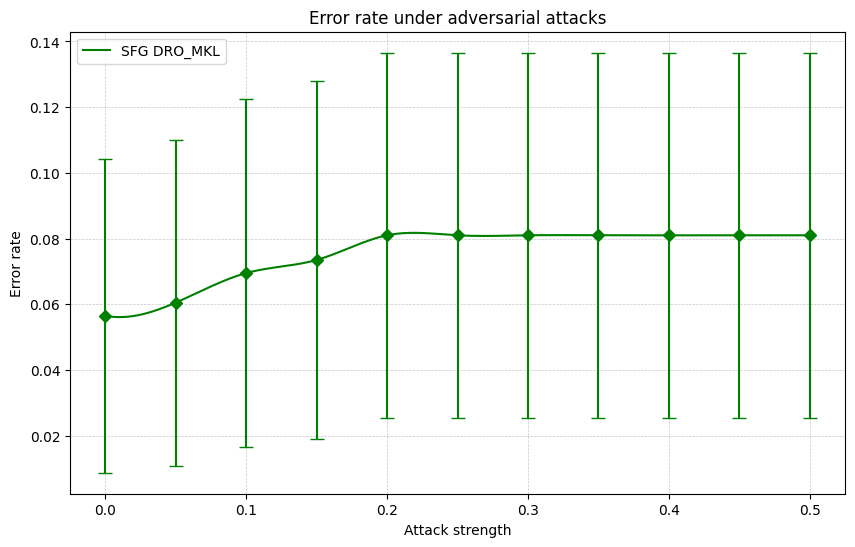

Error Rates under Adversarial Attacks:

Attack Strength		SFG DRO_MKL		
--------------------------------------------------
0.00			0.0565			
0.05			0.0605			
0.10			0.0695			
0.15			0.0735			
0.20			0.0810			
0.25			0.0810			
0.30			0.0810			
0.35			0.0810			
0.40			0.0810			
0.45			0.0810			
0.50			0.0810			


In [15]:
results = [results_sfg_MKL]

# Corresponding labels for the legend
labels = ['SFG DRO_MKL']

# Colors for the plot lines
colors = ['green', ]

# Markers for the error bar
markers = ['D', 's']  # D is for diamond shape, s is for square shape

# Title for the plot
title = 'Error rate under adversarial attacks'

# Call the function to plot error rates
plot_error_rates(results, labels, colors, markers, title)